<a href="https://colab.research.google.com/github/Alex-Chen1121/Machine-learning/blob/main/Keras_Vgg16_%E9%81%B7%E7%A7%BB%E5%AD%B8%E7%BF%92.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!gdown --id 1ngv0KTuqCOIxUJ-62vHXzvqrzmre6hw- --output train.zip
!unzip train.zip

In [ ]:
from keras.applications.vgg16 import VGG16

# include_top:需不需要腦袋的部分
# weights:在imagnet上訓練的初始權重
# input_tensor:使用keras tensor來當輸出的tensor
# 只取模型眼睛的部分 (捲積)
vgg= VGG16(input_shape=(224, 224, 3), include_top=False)
vgg.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [ ]:
import glob
import pandas as pd

# 先不讀圖片 因為ram不夠 真的要訓練才讀
df=pd.DataFrame(columns=["path", "target"]
                )
for p in glob.glob("train/cat.*.jpg"):
  s= pd.Series([p,0], index=["path", "target"]) # 創建一列 用append方法新增到dataframe
  df = df.append(s, ignore_index=True)

for p in glob.glob("train/dog.*.jpg"):
  s= pd.Series([p,1], index=["path", "target"])
  df = df.append(s, ignore_index=True)


串流輸出內容已截斷至最後 5000 行。
<ipython-input-70-bab2ea86f748>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(s, ignore_index=True)
<ipython-input-70-bab2ea86f748>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(s, ignore_index=True)
<ipython-input-70-bab2ea86f748>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(s, ignore_index=True)
<ipython-input-70-bab2ea86f748>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(s, ignore_index=True)
<ipython-input-70-bab2ea86f748>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use p

In [ ]:
df

,path,target
0,train/cat.832.jpg,0
1,train/cat.4679.jpg,0
2,train/cat.11013.jpg,0
3,train/cat.3752.jpg,0
4,train/cat.3588.jpg,0
...,...,...
24995,train/dog.3742.jpg,1
24996,train/dog.7395.jpg,1
24997,train/dog.1330.jpg,1
24998,train/dog.4588.jpg,1


train/dog.9005.jpg
(500, 390)


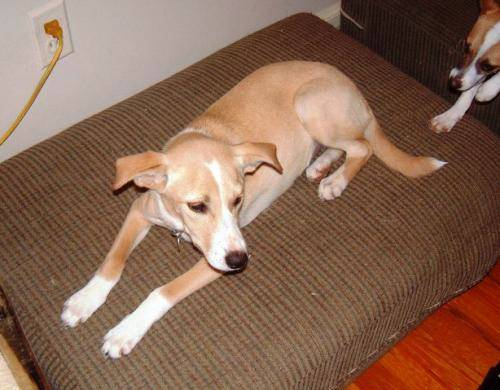

In [ ]:
from keras.utils import load_img
import random
c= random.randint(0, 24999)
print(df["path"][c])
img= load_img(df["path"][c])
print(img.size)
img

(224, 224)


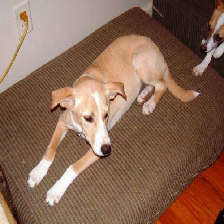

In [ ]:
img= load_img(df["path"][c], target_size=(224,224))
print(img.size)
img

In [ ]:
from keras.models import Model
from keras.layers import Flatten, Dense, BatchNormalization

# Flatten: 攤開成一維
# Dense : 全連接層

In [ ]:
# vgg.output 偷眼睛的最後一層輸出
# Flatten()做完還是一個方法 所以要用Flatten()()再接一個括號來使用
# cnn眼睛
for l in vgg.layers:
  l.trainable = False
# bn血管
x = BatchNormalization()(vgg.output)

# mlp大腦
x = Flatten()(vgg.output)
x = Dense(units=2048, activation="relu")(x)
x = Dense(units=256, activation="relu")(x)
# 在貓和狗的分類中 units = 1 or units = 2 都可以
#          sigmoid輸出   softmax輸出
x = Dense(units=2, activation="softmax")(x)
# 建立模型 帶入輸入&輸出
cnn = Model(inputs=vgg.input, outputs=x)
cnn.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
# 是一個列表 可以拿特定的層
vgg.layers

In [ ]:
cnn.compile(loss="categorical_crossentropy",
      optimizer="adam",
      metrics=["accuracy"])

In [ ]:
# 切分資料
from sklearn.model_selection import train_test_split
# 真的要開始切分和訓練的時候 把pandas轉成numpy的array (會有dataframe的index問題)
import numpy as np

from keras.utils.np_utils import to_categorical
y_cat = to_categorical(df["target"])
x_train,x_test,y_train,y_test = train_test_split(np.array(df["path"]),np.array(y_cat), test_size=0.1)

In [ ]:
y_cat[0]

array([1., 0.], dtype=float32)

In [ ]:
# 偷誰的模型 就要用他的資料預處理方式
from keras.applications.vgg16 import preprocess_input
batch_size = 10
for i in range(30):
  # randint(下限,上限(不包括),幾個)
  idx = np.random.randint(0, x_train.shape[0], batch_size)
  # numpy 好處:array[索引list] 花式索引
  imgs = []
  for fn in x_train[idx]:
    # 讀取圖片並使用模型的預處理方式
    img= load_img(fn, target_size=(224,224))
    img = preprocess_input(np.array(img))
    imgs.append(img)

  x = np.array(imgs)
  y = y_train[idx]
  result = cnn.train_on_batch(x,y)
  print("----------Times", i, "--------")
  print(result)

----------Times 0 --------
[4.45760440826416, 0.8999999761581421]
----------Times 1 --------
[21.9121036529541, 0.800000011920929]
----------Times 2 --------
[0.0, 1.0]
----------Times 3 --------
[1.0605716705322266, 0.8999999761581421]
----------Times 4 --------
[6.4518890380859375, 0.8999999761581421]
----------Times 5 --------
[1.192092735635697e-08, 1.0]
----------Times 6 --------
[25.572031021118164, 0.800000011920929]
----------Times 7 --------
[7.668431758880615, 0.8999999761581421]
----------Times 8 --------
[0.0, 1.0]
----------Times 9 --------
[3.042881727218628, 0.800000011920929]
----------Times 10 --------
[11.39317798614502, 0.699999988079071]
----------Times 11 --------
[8.942180633544922, 0.8999999761581421]
----------Times 12 --------
[6.712396144866943, 0.800000011920929]
----------Times 13 --------
[0.14724333584308624, 0.8999999761581421]
----------Times 14 --------
[3.3457541465759277, 0.800000011920929]
----------Times 15 --------
[0.0, 1.0]
----------Times 16 ---

In [ ]:
batch_size = 200

# randint(下限,上限(不包括),幾個)
idx = np.random.randint(0, x_test.shape[0], batch_size)
# numpy 好處:array[索引list] 花式索引
imgs = []
oriimglist = []
for fn in x_test[idx]:
  # 讀取圖片並使用模型的預處理方式
  img= load_img(fn, target_size=(224,224))
  # 先把原圖留下來
  oriimglist.append(img)
  img = preprocess_input(np.array(img))
  imgs.append(img)

x = np.array(imgs)
y = y_test[idx]
cnn.evaluate(x,y)

7/7 [==============================] - 121s 17s/step - loss: 1.6687 - accuracy: 0.9650


[1.6686824560165405, 0.9649999737739563]

In [ ]:
pre = cnn.predict(x).argmax(axis=-1)
pre

7/7 [==============================] - 123s 17s/step


array([0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0,
       1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1,
       1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0,
       1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 1])

In [ ]:
np.nonzero(pre != y.argmax(axis=-1))

(array([ 28,  39,  41,  50, 113, 128, 178]),)

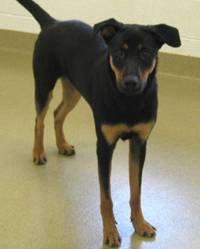

In [ ]:
# 畫出錯誤的圖片
img = load_img(x_test[128])
img

In [ ]:
# 思考為何會有此結果
cnn.predict(x)
# 結果
# 7/7 [==============================] - 122s 17s/step
# array([[0.        , 0.99999994],
#        [0.        , 0.99999994],
#        [0.        , 0.99999994],
#        [0.        , 0.99999994],
#        [0.        , 0.99999994],
#        [0.        , 0.99999994],
#        [0.        , 0.99999994],
#        [0.        , 0.99999994],
#        [0.        , 0.99999994],
#        [0.        , 0.99999994],
#        [0.        , 0.99999994],
#        [0.        , 0.99999994],